**1/14/21**

The purpose of this notebook is to analyze human proteins I identify and see which are significantly differentially abundant based on BV status.

In [1]:
from elliot_utils import *
from scipy import stats

In [2]:
analysisPath = Path.cwd().joinpath('analysis_files/human_analysis/')
figPath = Path.cwd().joinpath('figures/human_analysis/')

In [3]:
results = getOrderedFiles(HYBRID_RESULTS, '.tsv')
dbs = getOrderedFiles(HYBRID_DB, '.fasta')
refs = [ProtRef(x) for x in dbs]
hPeps = getFilteredPeptides(results, 'human')

In [4]:
# Get a dictionary of all the human proteins identified by Hybrid_Sample-Matched searches
humanProteins = {} #key=protID, value=protein object

In [5]:
for i in range(len(results)):
    ref = refs[i]
    res = results[i]
    with res.open(mode='r') as infile:
        reader = csv.reader(infile, delimiter='\t')
        for row in reader:
            protType = determineIDType(row)
            if protType == 'first':
                continue
            if not isSignificant(row):
                break
            if row[PEPTIDE] in hPeps and protType == 'human':
                hits = getProteinHitList(row, 'human')
                for hit in hits:
                    if not hit in humanProteins.keys():
                        humanProteins[hit] = ref.getProt(hit)

In [6]:
# Get the transformed relative abundance for each human protein across all the samples
sampleTotals = [0 for x in range(len(SAMPLE_NAMES))] # Total number of significant human PSMs for each sample.
humanCounts = {} #key=protID, value=spectral count of the protein in each sample
for p in humanProteins.keys():
    humanCounts[p] = [0 for x in range(len(SAMPLE_NAMES))]

In [7]:
for i in range(len(results)):
    with results[i].open(mode='r') as infile:
        reader = csv.reader(infile, delimiter='\t')
        for row in reader:
            protType = determineIDType(row)
            if protType == 'first':
                continue
            if not isSignificant(row):
                break
            if row[PEPTIDE] in hPeps and protType == 'human':
                sampleTotals[i] += 1
                hits = getProteinHitList(row, 'human')
                for hit in hits:
                    humanCounts[hit][i] += 1

In [8]:
# Returns true if all the numbers in the list are 0, false otherwise
def allZeros(numList):
    for num in numList:
        if not num == 0:
            return False
    return True

# Returns the mean of the array
def mean(numList):
    return sum(numList) / len(numList)

In [11]:
# Separate counts into BV+ and BV-, then log-transform them
bvPlusCounts = {} #key=protID, value=list of counts in BV+ samples
bvMinusCounts = {} #key=protID, value=list of counts in BV- samples
bvPlusTransformed = {} #key=protID, value=list of transformed abundances in BV+ samples
bvMinusTransformed = {} #key=protID, value=list of transformed abundances in BV- samples
bvPlusStdv = {} #key=protID, value=standard deviation of transformed abundances in BV+ samples
bvMinusStdv = {} #key=protID, value=standard deviation of transformed abundances in BV+ samples

In [12]:
for p in humanProteins.keys():
    if allZeros(humanCounts[p]): #Ignore proteins that were never hit
        continue
    bvPlusCounts[p] = []
    bvMinusCounts[p] = []
    bvPlusTransformed[p] = []
    bvMinusTransformed[p] = []
    bvPlusStdv[p] = None
    bvMinusStdv[p] = None

In [14]:
for i in range(len(SAMPLE_NAMES)):
    for p in bvPlusCounts.keys():
        if BV_STATUS[i] == '+':
            bvPlusCounts[p].append(humanCounts[p][i])
            bvPlusTransformed[p].append(math.log2(1 + (humanCounts[p][i] / sampleTotals[i])))
        else:
            bvMinusCounts[p].append(humanCounts[p][i])
            bvMinusTransformed[p].append(math.log2(1 + (humanCounts[p][i] / sampleTotals[i])))
for p in bvPlusCounts.keys():
    bvPlusStdv[p] = stats.tstd(bvPlusTransformed[p])
    bvMinusStdv[p] = stats.tstd(bvMinusTransformed[p])

In [15]:
# Test whether the proteins are significantly differentially abundant using the mann-whitney U test
pvals = {} #key=protID, value=p-value of mann-whitney U test

In [16]:
for p in bvPlusCounts.keys():
    negData = bvMinusTransformed[p]
    posData = bvPlusTransformed[p]
    res = stats.mannwhitneyu(bvMinusTransformed[p], bvPlusTransformed[p])
    pVal = res.pvalue
    pvals[p] = pVal

In [17]:
with analysisPath.joinpath('differential_proteins_human.csv').open(mode='w', newline='') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['Protein', 'p-value', 'BV- Avg Count', 'BV- Avg Transformed Abundance', 'BV- StDev', 'BV+ Avg Count', 'BV+ Avg Transformed Abundance', 'BV+ StDev', 'delta'])
    for p in bvPlusCounts.keys():
        writer.writerow([humanProteins[p].name, str(pvals[p]), str(mean(bvMinusCounts[p])), str(mean(bvMinusTransformed[p])), str(bvMinusStdv[p]), str(mean(bvPlusCounts[p])), str(mean(bvPlusTransformed[p])), str(bvPlusStdv[p]), str(mean(bvPlusCounts[p]) - mean(bvMinusCounts[p]))])

In [39]:
# Perform the same analysis with GO annotations associated with the proteins
annotations = {} #key=protein ID, value=list of GO numbers associated with the protein
for p in humanProteins.keys():
    annotations[p] = []

In [56]:
annotationFile = pd.read_csv(Path.cwd().joinpath('analysis_files/functional_analysis/eggnog_annotations_human.tsv'), sep='\t')
annotationCounts = {'unannotated':[0 for x in range(len(SAMPLE_NAMES))]} #key=GO number, value=list of spectral counts associated with that GO number in each sample

In [57]:
# Get protein -> annotations associations, and also pull out all the annotations associated with all human proteins into another dict
for index, row in annotationFile.iterrows():
    prot = row['query']
    gostring = row['GOs']
    if gostring == '-':
        annotations[prot] = ['unannotated']
    else:
        goList = gostring.split(',')
        annotations[prot] = goList
        for go in goList:
            annotationCounts[go] = [0 for x in range(len(SAMPLE_NAMES))]
for p in annotations.keys():
    if len(annotations[p]) == 0:
        annotations[p] = ['unannotated']

In [58]:
# Get spectral counts for annotations
for i in range(len(results)):
    with results[i].open(mode='r') as infile:
        reader = csv.reader(infile, delimiter='\t')
        for row in reader:
            protType = determineIDType(row)
            if protType == 'first':
                continue
            if not isSignificant(row):
                break
            if row[PEPTIDE] in hPeps and protType == 'human':
                hits = getProteinHitList(row, 'human')
                for hit in hits:
                    for go in annotations[hit]:
                        annotationCounts[go][i] += 1

In [59]:
# Separate annotation counts into BV+ and BV-, then log-transform them
bvPlusAnotCounts = {} #key=protID, value=list of counts in BV+ samples
bvMinusAnotCounts = {} #key=protID, value=list of counts in BV- samples
bvPlusAnotTransformed = {} #key=protID, value=list of transformed abundances in BV+ samples
bvMinusAnotTransformed = {} #key=protID, value=list of transformed abundances in BV- samples

In [62]:
for a in annotationCounts.keys():
    if allZeros(annotationCounts[a]): #Ignore annotations that were never hit
        continue
    bvPlusAnotCounts[a] = []
    bvMinusAnotCounts[a] = []
    bvPlusAnotTransformed[a] = []
    bvMinusAnotTransformed[a] = []

In [63]:
for i in range(len(SAMPLE_NAMES)):
    for a in bvPlusAnotCounts.keys():
        if BV_STATUS[i] == '+':
            bvPlusAnotCounts[a].append(annotationCounts[a][i])
            bvPlusAnotTransformed[a].append(math.log2(1 + (annotationCounts[a][i] / sampleTotals[i])))
        else:
            bvMinusAnotCounts[a].append(annotationCounts[a][i])
            bvMinusAnotTransformed[a].append(math.log2(1 + (annotationCounts[a][i] / sampleTotals[i])))

In [71]:
# Test whether the proteins are significantly differentially abundant using the mann-whitney U test
annotpvals = {} #key=protID, value=p-value of mann-whitney U test

In [72]:
for a in bvPlusAnotCounts.keys():
    negData = bvMinusAnotTransformed[a]
    posData = bvPlusAnotTransformed[a]
    res = stats.mannwhitneyu(bvMinusAnotTransformed[a], bvPlusAnotTransformed[a])
    pVal = res.pvalue
    annotpvals[a] = pVal

In [64]:
goref = GoRef(Path.cwd().joinpath('analysis_files/go.obo'))

In [73]:
with analysisPath.joinpath('differential_annotations_human.csv').open(mode='w', newline='') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['GO', 'Annotation', 'p-value', 'BV- Avg Count', 'BV- Avg Transformed Abundance', 'BV+ Avg Count', 'BV+ Avg Transformed Abundance'])
    for a in bvPlusAnotCounts.keys():
        function = a if a == 'unannotated' else goref.getFunc(a)
        writer.writerow([a, function, str(annotpvals[a]), str(mean(bvMinusAnotCounts[a])), str(mean(bvMinusAnotTransformed[a])), str(mean(bvPlusAnotCounts[a])), str(mean(bvPlusAnotTransformed[a]))])

How many human PSMs do I get in BV- vs. BV+ samples? How many different human proteins, on average, do I see in BV- vs. BV+ samples?

In [8]:
psmCounts = []
protCounts = []

In [9]:
# Count PSMs and proteins by BV status
for i in range(len(results)):
    with results[i].open(mode='r') as infile:
        reader = csv.reader(infile, delimiter='\t')
        psmCount = 0
        allHitProts = set()
        for row in reader:
            protType = determineIDType(row)
            if protType == 'first':
                continue
            if not isSignificant(row):
                break
            if row[PEPTIDE] in hPeps and protType == 'human':
                psmCount += 1
                hits = getProteinHitList(row, 'human')
                for hit in hits:
                    allHitProts.add(hit)
        psmCounts.append(psmCount)
        protCounts.append(len(allHitProts))

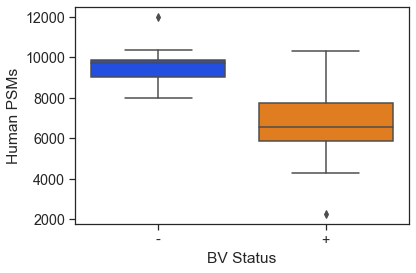

In [14]:
psmDF = pd.DataFrame({'Human PSMs':psmCounts, 'BV Status':BV_STATUS})
psmsPlot = sns.boxplot(data=psmDF, x='BV Status', y='Human PSMs')
saveFig(psmsPlot, figPath.joinpath('psms_by_bv.png'))

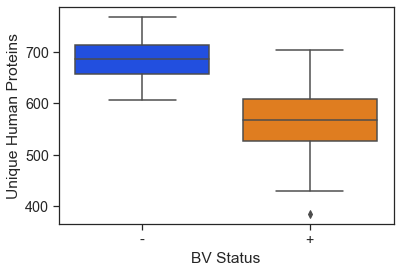

In [15]:
protDF = pd.DataFrame({'Unique Human Proteins':protCounts, 'BV Status':BV_STATUS})
protPlot = sns.boxplot(data=protDF, x='BV Status', y='Unique Human Proteins')
saveFig(protPlot, figPath.joinpath('prots_by_bv.png'))